In [52]:
from datetime import datetime 

from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Урок 6. Градиентный бустинг. AdaBoost.

In [7]:
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [36]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

1.Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [89]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth, fit_seconds):
    print()    
    
    start_time = datetime.now()
    train_prediction = gb_predict(X_train, trees, coefs, eta)  
    predict_seconds = (datetime.now() - start_time).total_seconds()
    print(f'train\t{mean_squared_error(y_train, train_prediction):.0f}\t{n_trees}\t{max_depth}\t{eta}\t{fit_seconds:.3f}\t{predict_seconds:.3f}')

    start_time = datetime.now()
    test_prediction = gb_predict(X_test, trees, coefs, eta)  
    predict_seconds = (datetime.now() - start_time).total_seconds()
    print(f'test\t{mean_squared_error(y_test, test_prediction):.0f}\t{n_trees}\t{max_depth}\t{eta}\t{fit_seconds:.3f}\t{predict_seconds:.3f}')
    
    
def get_error_plot(n_trees, train_err, test_err):
    

In [114]:
# Число деревьев в ансамбле
n_trees = [10, 25, 50, 100]

# для простоты примем коэффициенты равными 1
coefs = [el * [1] for el in n_trees]

# Максимальная глубина деревьев
max_depth = [3, 5, 10, 20]

# Шаг
eta = 0.1

# Массивы наборов ошибок и решающих деревьев
trees_arr = []
train_errors_arr = []
test_errors_arr = []

In [115]:
print(f'\terror\ttrees\tmax\teta\tgb fit\tpredict')
print(f'\t\t\tdepth\t\ttime, s\ttime, s')

for i in range(len(n_trees)):
    start_time = datetime.now()
    trees, train_errors, test_errors = gb_fit(n_trees[i], max_depth[0], X_train, X_test, y_train, y_test, coefs[i], eta)
    seconds = (datetime.now() - start_time).total_seconds()

    trees_arr.append(trees)
    train_errors_arr.append(train_errors)
    test_errors_arr.append(test_errors)
    
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs[i], eta, n_trees[i], max_depth[i], seconds)

	error	trees	depth	eta	gb fit	predict
			max		time, s	time, s

train	5503	10	3	0.1	2.162	0.209
test	7851	10	3	0.1	2.162	0.073

train	1979	25	5	0.1	14.282	0.506
test	4154	25	5	0.1	14.282	0.171


KeyboardInterrupt: 

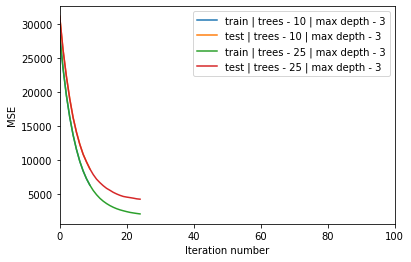

In [152]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, max(n_trees))

for i in range(len(n_trees) - 2):  
    plt.plot(list(range(n_trees[i])), train_errors_arr[i], label=f'train | trees - {n_trees[i]} | max depth - {max_depth[0]}')
    plt.plot(list(range(n_trees[i])), test_errors_arr[i], label=f'test | trees - {n_trees[i]} | max depth - {max_depth[0]}')
       
plt.legend(loc='upper right')
plt.show()

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.